In [1]:
import torch, torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

In [2]:
batch_size = 180
# stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
stats = (0, 0, 0), (1, 1, 1)
# transform = transforms.Compose([transforms.Resize(64), # RESIZE SIZE MIGHT BE WRONG, WHO KNOWS
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(*stats)])
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(*stats)])


def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

class ImageData(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.frame = []
        for file in os.listdir(root):
            f = os.path.join(root, file)
            if os.path.isfile(f):
                self.frame.append(f)
    
    def __len__(self):
        return len(self.frame)
    
    
    def __getitem__(self, index):
        image_name = self.frame[index]
        image = Image.open(image_name)
        if self.transform:
            image = self.transform(image)
        return image

rootTrain = './VD_dataset2/input_all'
rootLabel = './VD_dataset2/target_all'
trainset = ImageData(root=rootTrain, transform=transform)
labelset = ImageData(root=rootLabel, transform=transform)

batch_size = 100

trainLoader = DataLoader(trainset, batch_size, shuffle=False, num_workers=0)
labelLoader = DataLoader(labelset, batch_size, shuffle=False, num_workers=0)



if torch.cuda.is_available():
    device=torch.device('cuda')
    print('Cuda!')
else:
    device=torch.device('cpu')
    print('CPU :(')

Cuda!


Function to show a pair of images for comparison

In [3]:
def show_ims(img_real, img_filt):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xticks([]) 
    ax.set_yticks([])
    plt.axis('off')
    fig.add_subplot(1,2,1)
    plt.imshow(denorm(img_real))
    
    fig.add_subplot(1,2,2)
    plt.imshow(denorm(img_filt))

Obtain a handful of images and their conversions

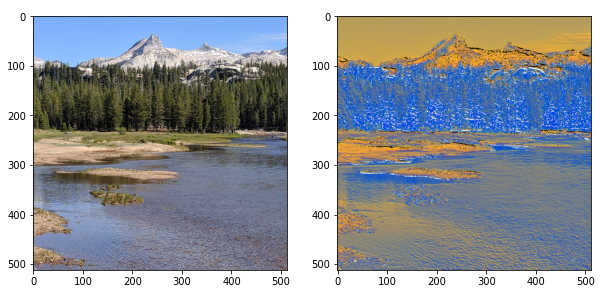

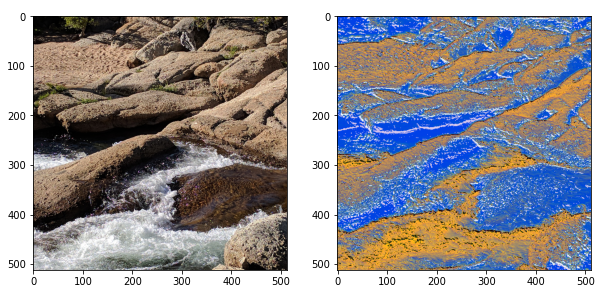

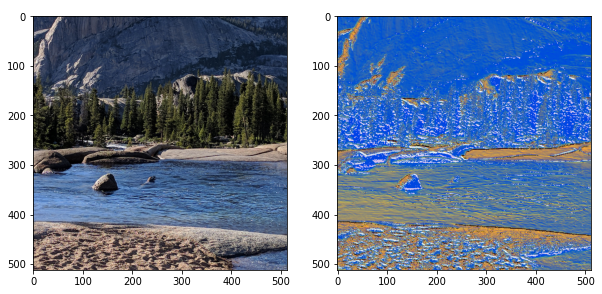

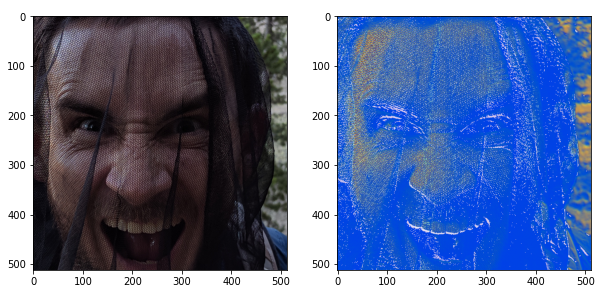

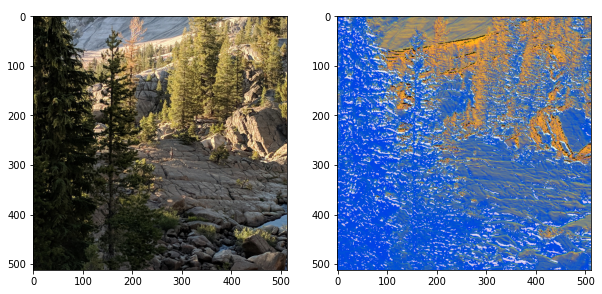

In [4]:
for (real_images, tran_images) in zip(trainLoader, labelLoader):
    real_images = real_images.to(device)
    tran_images = tran_images.to(device)
    temp_im_rea = real_images
    
    temp_lb_rea = tran_images
    break

for indx in range(5):
    temp_im_rea[indx].shape
    temp_lb_rea[indx].shape

    sh_im_rea = np.transpose( np.array(temp_im_rea[indx].cpu().detach().numpy()), (1,2,0))
    sh_lb_rea = np.transpose( np.array(temp_lb_rea[indx].cpu().detach().numpy()), (1,2,0))

    show_ims(sh_im_rea, sh_lb_rea)


Check the relation between the color of the pixels (combined into a single integer) from the original and the target picture

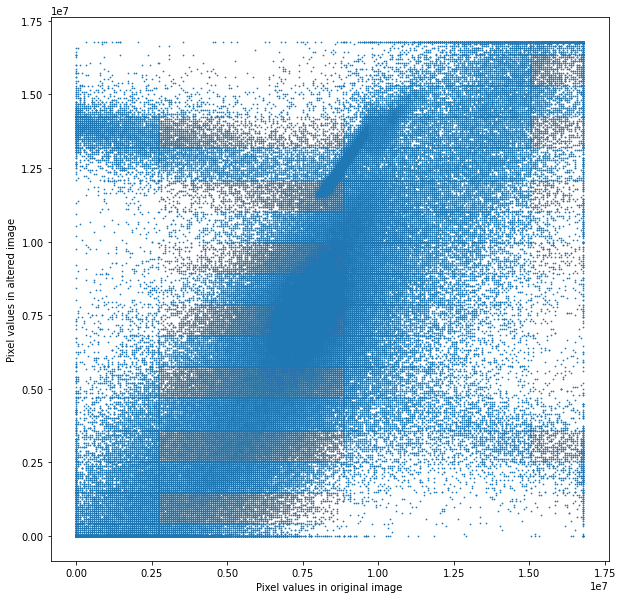

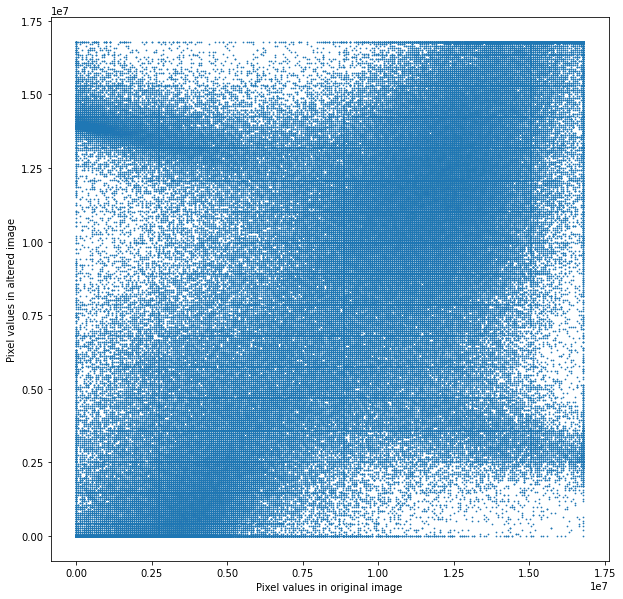

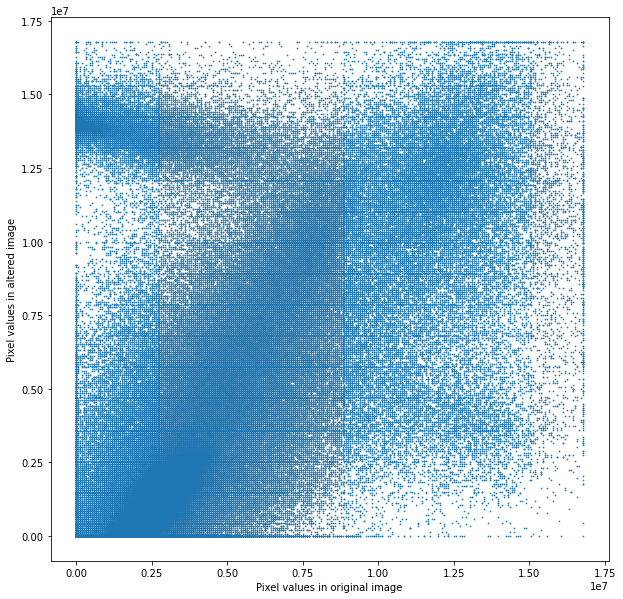

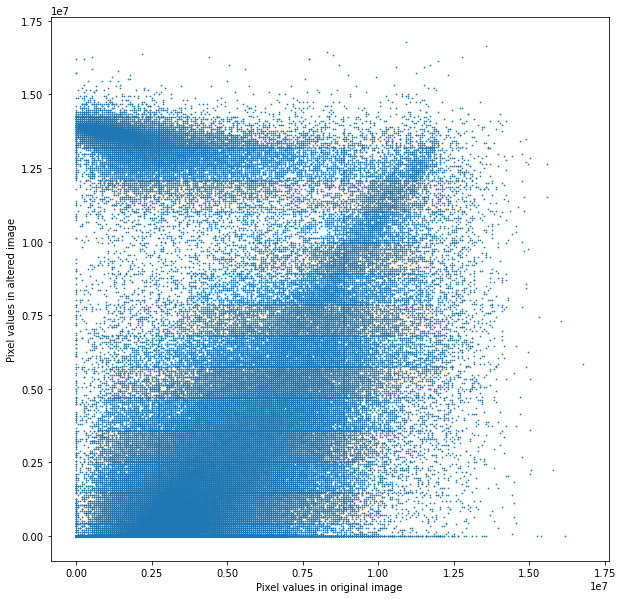

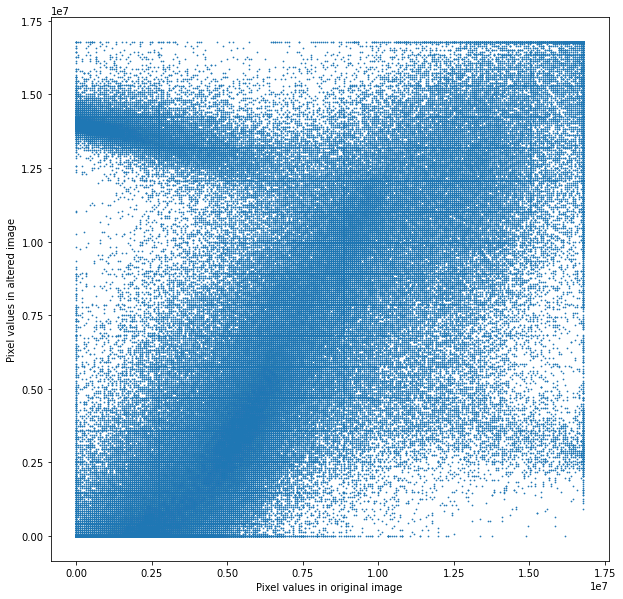

In [5]:
indx = 0

def getSingleColor(imag):
    im_r = 255*imag[:,:,0].flatten()
    im_r = im_r.astype(int)
    im_g = 255*imag[:,:,1].flatten()
    im_g = im_r.astype(int)
    im_b = 255*imag[:,:,2].flatten()
    im_b = im_r.astype(int)
    
    im_all = im_r
    im_all = (im_all<<8) + im_g
    im_all = (im_all<<8) + im_b
    return im_all
    

for indx in range(5):

    sh_im_rea = np.transpose( np.array(temp_im_rea[indx].cpu().detach().numpy()), (1,2,0))
    sh_lb_rea = np.transpose( np.array(temp_lb_rea[indx].cpu().detach().numpy()), (1,2,0))

    fig = plt.figure(figsize=(10,10))
    plt.scatter(getSingleColor(sh_im_rea),  getSingleColor(sh_lb_rea), s=0.5)
    plt.xlabel('Pixel values in original image')
    plt.ylabel('Pixel values in altered image')


The relation is not bijective, meaning that one single pixel is not unambiguously mapped to a transformed pixel based on the color. Then, by looking a the images, it is clear that the conversion is some sort of filter(s) applied to the original images. So, the idea is to do apply a CNN to learn the filter(s) used for conversion. 

The input of the CNN is an original image, and the loss function is an MSE obtained by comparing the outttput image to a transformed image pixel by pixel. Afterwards, a L1 loss is used so that small pixel errors are also taken into account



**CNN (a single layer with 3 kernels of (3, 3), which would amount to a filter on the original image)**

In [8]:
class Filter1NN(nn.Module):
    def __init__(self,inchannels):
        super(Filter1NN,self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(in_channels=inchannels, 
                               out_channels=3, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1)
        self.lrelu1 = nn.Tanh()
        self.conv2 = nn.ConvTranspose2d(in_channels=3, 
                               out_channels=3, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1)
        self.lrelu2 = nn.Tanh()
        self.conv4 = nn.ConvTranspose2d(in_channels=3, 
                               out_channels=3, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1)
        self.sigm = nn.Sigmoid()

    def forward(self,x):
        x = self.conv1(x)
        x = self.lrelu1(x)
        x = self.conv2(x )
        x = self.lrelu2(x)
        x = self.conv4(x)
        return self.sigm(x)
        
F=Filter1NN(3).to(device)

**Loss function (MSE or L1 over all the pixels, set manually)**

In [19]:
def filter_loss(img_real,img_filt):
    loss = torch.nn.L1Loss()
#     loss = torch.nn.MSELoss()
    
    im1 = img_real.reshape(-1)*255
    im2 = img_filt.reshape(-1)*255
    return loss(im1,im2)


**Optimizer (ADAM)**

In [10]:
lr=0.1
opt = optim.Adam(F.parameters(), lr=lr, weight_decay=0.0001) 

**Training**

In [20]:
lossvec = []
def train(F, opt, epochs=1):
    ep_c = 0
    F.train()
    for epoch in range(epochs):
        bt_c = 0
        templossvec = []
        for (real_images, tran_images) in zip(trainLoader, labelLoader):
            real_images = real_images.to(device)
            tran_images = tran_images.to(device)
            
            opt.zero_grad()
            conv_images = F(real_images)
            loss = filter_loss(tran_images,conv_images)
            
            loss.backward()
            opt.step()
            
            templossvec.append(loss.item())
            lossvec.append(loss.item())
            print("[Epoch: {} / Batch: {}] Loss = {}".format(
                    ep_c, bt_c, loss.item()))
            bt_c = bt_c + 1
#         lossvec.append(np.mean(np.array(templossvec)))
        ep_c = ep_c + 1
        
            
train(F,opt,epochs=200)

[Epoch: 0 / Batch: 0] Loss = 17.523164749145508
[Epoch: 0 / Batch: 1] Loss = 21.566898345947266
[Epoch: 0 / Batch: 2] Loss = 28.155658721923828
[Epoch: 0 / Batch: 3] Loss = 33.29867935180664
[Epoch: 0 / Batch: 4] Loss = 36.297542572021484
[Epoch: 0 / Batch: 5] Loss = 41.545013427734375
[Epoch: 0 / Batch: 6] Loss = 44.613407135009766
[Epoch: 0 / Batch: 7] Loss = 43.67322540283203
[Epoch: 0 / Batch: 8] Loss = 45.11073303222656
[Epoch: 0 / Batch: 9] Loss = 43.47465133666992
[Epoch: 0 / Batch: 10] Loss = 41.1771354675293
[Epoch: 0 / Batch: 11] Loss = 39.56914520263672
[Epoch: 0 / Batch: 12] Loss = 41.14670944213867
[Epoch: 1 / Batch: 0] Loss = 34.20270919799805
[Epoch: 1 / Batch: 1] Loss = 32.0038948059082
[Epoch: 1 / Batch: 2] Loss = 30.881982803344727
[Epoch: 1 / Batch: 3] Loss = 29.453989028930664
[Epoch: 1 / Batch: 4] Loss = 28.320863723754883
[Epoch: 1 / Batch: 5] Loss = 27.132522583007812
[Epoch: 1 / Batch: 6] Loss = 25.305795669555664
[Epoch: 1 / Batch: 7] Loss = 24.559114456176758


[Epoch: 13 / Batch: 2] Loss = 13.590048789978027
[Epoch: 13 / Batch: 3] Loss = 14.17162799835205
[Epoch: 13 / Batch: 4] Loss = 14.803627967834473
[Epoch: 13 / Batch: 5] Loss = 13.146256446838379
[Epoch: 13 / Batch: 6] Loss = 12.14926528930664
[Epoch: 13 / Batch: 7] Loss = 12.756172180175781
[Epoch: 13 / Batch: 8] Loss = 12.096009254455566
[Epoch: 13 / Batch: 9] Loss = 14.049910545349121
[Epoch: 13 / Batch: 10] Loss = 13.12128734588623
[Epoch: 13 / Batch: 11] Loss = 13.138418197631836
[Epoch: 13 / Batch: 12] Loss = 9.505900382995605
[Epoch: 14 / Batch: 0] Loss = 15.00546932220459
[Epoch: 14 / Batch: 1] Loss = 11.033557891845703
[Epoch: 14 / Batch: 2] Loss = 13.556564331054688
[Epoch: 14 / Batch: 3] Loss = 14.136662483215332
[Epoch: 14 / Batch: 4] Loss = 14.762347221374512
[Epoch: 14 / Batch: 5] Loss = 13.095538139343262
[Epoch: 14 / Batch: 6] Loss = 12.097716331481934
[Epoch: 14 / Batch: 7] Loss = 12.70510196685791
[Epoch: 14 / Batch: 8] Loss = 12.05463981628418
[Epoch: 14 / Batch: 9] L

[Epoch: 26 / Batch: 1] Loss = 10.688897132873535
[Epoch: 26 / Batch: 2] Loss = 13.194875717163086
[Epoch: 26 / Batch: 3] Loss = 13.718268394470215
[Epoch: 26 / Batch: 4] Loss = 14.321237564086914
[Epoch: 26 / Batch: 5] Loss = 12.603161811828613
[Epoch: 26 / Batch: 6] Loss = 11.683548927307129
[Epoch: 26 / Batch: 7] Loss = 12.29695987701416
[Epoch: 26 / Batch: 8] Loss = 11.679682731628418
[Epoch: 26 / Batch: 9] Loss = 13.609355926513672
[Epoch: 26 / Batch: 10] Loss = 12.630000114440918
[Epoch: 26 / Batch: 11] Loss = 12.670403480529785
[Epoch: 26 / Batch: 12] Loss = 8.732719421386719
[Epoch: 27 / Batch: 0] Loss = 14.631377220153809
[Epoch: 27 / Batch: 1] Loss = 10.652338027954102
[Epoch: 27 / Batch: 2] Loss = 13.161541938781738
[Epoch: 27 / Batch: 3] Loss = 13.687747955322266
[Epoch: 27 / Batch: 4] Loss = 14.296257019042969
[Epoch: 27 / Batch: 5] Loss = 12.577593803405762
[Epoch: 27 / Batch: 6] Loss = 11.658876419067383
[Epoch: 27 / Batch: 7] Loss = 12.267577171325684
[Epoch: 27 / Batch:

[Epoch: 39 / Batch: 0] Loss = 14.330656051635742
[Epoch: 39 / Batch: 1] Loss = 10.347270965576172
[Epoch: 39 / Batch: 2] Loss = 12.887480735778809
[Epoch: 39 / Batch: 3] Loss = 13.422407150268555
[Epoch: 39 / Batch: 4] Loss = 14.038825035095215
[Epoch: 39 / Batch: 5] Loss = 12.30892562866211
[Epoch: 39 / Batch: 6] Loss = 11.390414237976074
[Epoch: 39 / Batch: 7] Loss = 11.984127044677734
[Epoch: 39 / Batch: 8] Loss = 11.340914726257324
[Epoch: 39 / Batch: 9] Loss = 13.328462600708008
[Epoch: 39 / Batch: 10] Loss = 12.332290649414062
[Epoch: 39 / Batch: 11] Loss = 12.376038551330566
[Epoch: 39 / Batch: 12] Loss = 8.440727233886719
[Epoch: 40 / Batch: 0] Loss = 14.310205459594727
[Epoch: 40 / Batch: 1] Loss = 10.32828140258789
[Epoch: 40 / Batch: 2] Loss = 12.869274139404297
[Epoch: 40 / Batch: 3] Loss = 13.404006004333496
[Epoch: 40 / Batch: 4] Loss = 14.020325660705566
[Epoch: 40 / Batch: 5] Loss = 12.290387153625488
[Epoch: 40 / Batch: 6] Loss = 11.371936798095703
[Epoch: 40 / Batch: 

[Epoch: 51 / Batch: 12] Loss = 8.280866622924805
[Epoch: 52 / Batch: 0] Loss = 14.103607177734375
[Epoch: 52 / Batch: 1] Loss = 10.141878128051758
[Epoch: 52 / Batch: 2] Loss = 12.682788848876953
[Epoch: 52 / Batch: 3] Loss = 13.21301555633545
[Epoch: 52 / Batch: 4] Loss = 13.830828666687012
[Epoch: 52 / Batch: 5] Loss = 12.105570793151855
[Epoch: 52 / Batch: 6] Loss = 11.18683910369873
[Epoch: 52 / Batch: 7] Loss = 11.766556739807129
[Epoch: 52 / Batch: 8] Loss = 11.124892234802246
[Epoch: 52 / Batch: 9] Loss = 13.13412094116211
[Epoch: 52 / Batch: 10] Loss = 12.118797302246094
[Epoch: 52 / Batch: 11] Loss = 12.154356956481934
[Epoch: 52 / Batch: 12] Loss = 8.270699501037598
[Epoch: 53 / Batch: 0] Loss = 14.0890531539917
[Epoch: 53 / Batch: 1] Loss = 10.129255294799805
[Epoch: 53 / Batch: 2] Loss = 12.669568061828613
[Epoch: 53 / Batch: 3] Loss = 13.199288368225098
[Epoch: 53 / Batch: 4] Loss = 13.817476272583008
[Epoch: 53 / Batch: 5] Loss = 12.092835426330566
[Epoch: 53 / Batch: 6] 

[Epoch: 64 / Batch: 11] Loss = 12.001063346862793
[Epoch: 64 / Batch: 12] Loss = 8.186959266662598
[Epoch: 65 / Batch: 0] Loss = 13.939081192016602
[Epoch: 65 / Batch: 1] Loss = 10.013662338256836
[Epoch: 65 / Batch: 2] Loss = 12.537028312683105
[Epoch: 65 / Batch: 3] Loss = 13.056272506713867
[Epoch: 65 / Batch: 4] Loss = 13.680843353271484
[Epoch: 65 / Batch: 5] Loss = 11.966692924499512
[Epoch: 65 / Batch: 6] Loss = 11.045939445495605
[Epoch: 65 / Batch: 7] Loss = 11.607404708862305
[Epoch: 65 / Batch: 8] Loss = 10.972694396972656
[Epoch: 65 / Batch: 9] Loss = 12.995061874389648
[Epoch: 65 / Batch: 10] Loss = 11.964415550231934
[Epoch: 65 / Batch: 11] Loss = 11.989927291870117
[Epoch: 65 / Batch: 12] Loss = 8.18384838104248
[Epoch: 66 / Batch: 0] Loss = 13.928561210632324
[Epoch: 66 / Batch: 1] Loss = 10.007583618164062
[Epoch: 66 / Batch: 2] Loss = 12.528217315673828
[Epoch: 66 / Batch: 3] Loss = 13.045936584472656
[Epoch: 66 / Batch: 4] Loss = 13.671220779418945
[Epoch: 66 / Batch

[Epoch: 77 / Batch: 10] Loss = 11.849479675292969
[Epoch: 77 / Batch: 11] Loss = 11.886320114135742
[Epoch: 77 / Batch: 12] Loss = 8.20439624786377
[Epoch: 78 / Batch: 0] Loss = 13.827013969421387
[Epoch: 78 / Batch: 1] Loss = 10.004443168640137
[Epoch: 78 / Batch: 2] Loss = 12.452184677124023
[Epoch: 78 / Batch: 3] Loss = 12.936223983764648
[Epoch: 78 / Batch: 4] Loss = 13.586050033569336
[Epoch: 78 / Batch: 5] Loss = 11.90843677520752
[Epoch: 78 / Batch: 6] Loss = 10.962383270263672
[Epoch: 78 / Batch: 7] Loss = 11.50161361694336
[Epoch: 78 / Batch: 8] Loss = 10.894896507263184
[Epoch: 78 / Batch: 9] Loss = 12.895590782165527
[Epoch: 78 / Batch: 10] Loss = 11.840960502624512
[Epoch: 78 / Batch: 11] Loss = 11.880974769592285
[Epoch: 78 / Batch: 12] Loss = 8.208123207092285
[Epoch: 79 / Batch: 0] Loss = 13.820690155029297
[Epoch: 79 / Batch: 1] Loss = 10.010977745056152
[Epoch: 79 / Batch: 2] Loss = 12.448119163513184
[Epoch: 79 / Batch: 3] Loss = 12.928319931030273
[Epoch: 79 / Batch:

[Epoch: 90 / Batch: 9] Loss = 12.823065757751465
[Epoch: 90 / Batch: 10] Loss = 11.756375312805176
[Epoch: 90 / Batch: 11] Loss = 11.842576026916504
[Epoch: 90 / Batch: 12] Loss = 8.215620994567871
[Epoch: 91 / Batch: 0] Loss = 13.769951820373535
[Epoch: 91 / Batch: 1] Loss = 10.13274097442627
[Epoch: 91 / Batch: 2] Loss = 12.413309097290039
[Epoch: 91 / Batch: 3] Loss = 12.853126525878906
[Epoch: 91 / Batch: 4] Loss = 13.559076309204102
[Epoch: 91 / Batch: 5] Loss = 11.9168062210083
[Epoch: 91 / Batch: 6] Loss = 10.902009963989258
[Epoch: 91 / Batch: 7] Loss = 11.461602210998535
[Epoch: 91 / Batch: 8] Loss = 10.892704010009766
[Epoch: 91 / Batch: 9] Loss = 12.816923141479492
[Epoch: 91 / Batch: 10] Loss = 11.750664710998535
[Epoch: 91 / Batch: 11] Loss = 11.841084480285645
[Epoch: 91 / Batch: 12] Loss = 8.212485313415527
[Epoch: 92 / Batch: 0] Loss = 13.767838478088379
[Epoch: 92 / Batch: 1] Loss = 10.14527702331543
[Epoch: 92 / Batch: 2] Loss = 12.410362243652344
[Epoch: 92 / Batch: 

[Epoch: 103 / Batch: 7] Loss = 11.482094764709473
[Epoch: 103 / Batch: 8] Loss = 10.89861011505127
[Epoch: 103 / Batch: 9] Loss = 12.742626190185547
[Epoch: 103 / Batch: 10] Loss = 11.703794479370117
[Epoch: 103 / Batch: 11] Loss = 11.834373474121094
[Epoch: 103 / Batch: 12] Loss = 8.15056037902832
[Epoch: 104 / Batch: 0] Loss = 13.761750221252441
[Epoch: 104 / Batch: 1] Loss = 10.29505443572998
[Epoch: 104 / Batch: 2] Loss = 12.367762565612793
[Epoch: 104 / Batch: 3] Loss = 12.820359230041504
[Epoch: 104 / Batch: 4] Loss = 13.570341110229492
[Epoch: 104 / Batch: 5] Loss = 11.923264503479004
[Epoch: 104 / Batch: 6] Loss = 10.83382511138916
[Epoch: 104 / Batch: 7] Loss = 11.485543251037598
[Epoch: 104 / Batch: 8] Loss = 10.899157524108887
[Epoch: 104 / Batch: 9] Loss = 12.73676586151123
[Epoch: 104 / Batch: 10] Loss = 11.701691627502441
[Epoch: 104 / Batch: 11] Loss = 11.834250450134277
[Epoch: 104 / Batch: 12] Loss = 8.144569396972656
[Epoch: 105 / Batch: 0] Loss = 13.762372016906738
[

KeyboardInterrupt: 

**Results**

Filter1NN(
  (conv1): ConvTranspose2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lrelu1): Tanh()
  (conv2): ConvTranspose2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lrelu2): Tanh()
  (conv4): ConvTranspose2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sigm): Sigmoid()
)


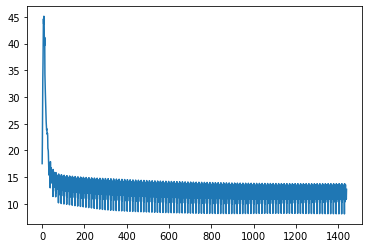

In [21]:
plt.plot(lossvec)
print(F)
# print(F.conv3.weight)

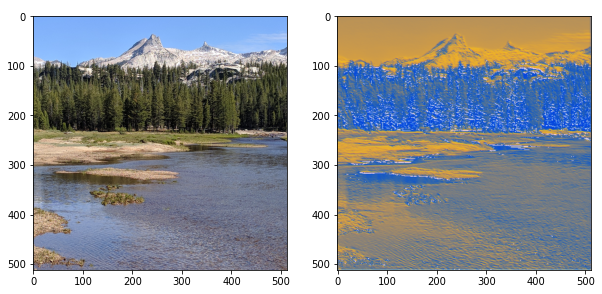

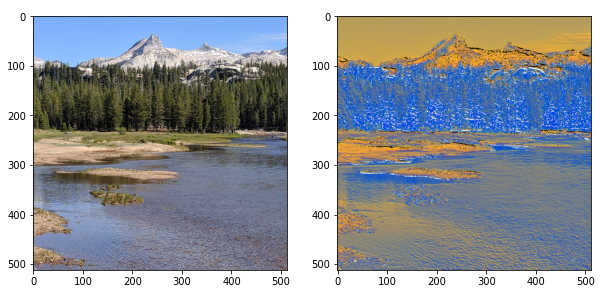

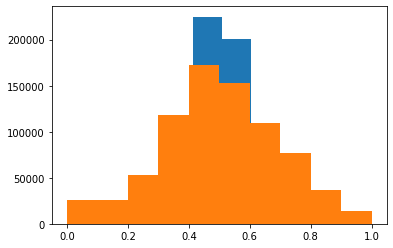

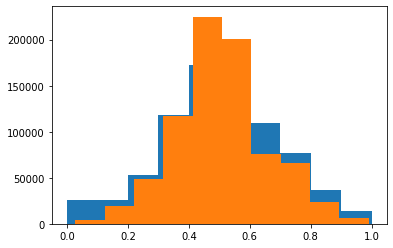

In [23]:
F.eval()
for (real_images, tran_images) in zip(trainLoader, labelLoader):
    real_images = real_images.to(device)
    tran_images = tran_images.to(device)
#     print(real_images.shape)
    temp_im_rea = real_images
    temp_im_aft = F(real_images)
    
    temp_lb_rea = tran_images
    temp_lb_aft = F(tran_images)
#     loss = filter_loss(temp_im_aft,temp_im_rea)
#     print(loss.item())
    break

indx = 0

temp_im_rea[indx].shape
temp_im_aft[indx].shape

sh_im_rea = np.transpose( np.array(temp_im_rea[indx].cpu().detach().numpy()), (1,2,0))
sh_im_aft = np.transpose( np.array(temp_im_aft[indx].cpu().detach().numpy()), (1,2,0))

show_ims(sh_im_rea, sh_im_aft)


temp_lb_rea[indx].shape
temp_lb_aft[indx].shape

sh_lb_rea = np.transpose( np.array(temp_lb_rea[indx].cpu().detach().numpy()), (1,2,0))
sh_lb_aft = np.transpose( np.array(temp_lb_aft[indx].cpu().detach().numpy()), (1,2,0))

show_ims(sh_im_rea, sh_lb_rea)

fig, ax = plt.subplots()
plt.hist(sh_lb_aft.flatten());
plt.hist(sh_lb_rea.flatten());

fig, ax = plt.subplots()
plt.hist(sh_lb_rea.flatten());
plt.hist(sh_lb_aft.flatten());

# fig = plt.figure(figsize=(10,10))
# plt.scatter(sh_lb_aft.flatten(), sh_lb_rea.flatten(), s=0.5)

# fig = plt.figure(figsize=(10,10))
# plt.scatter(getSingleColor(sh_lb_rea),  getSingleColor(sh_lb_aft), s=0.5)

[[[ 0.2013666   0.03816277 -0.04337543]
  [ 0.23044777  0.01928562 -0.01076785]
  [ 0.21212488  0.02355343 -0.02076852]
  ...
  [ 0.21948385  0.02936238 -0.01852399]
  [ 0.2689992   0.04500395 -0.06859627]
  [ 0.3414162   0.14970854 -0.22018203]]

 [[ 0.3761387   0.13603401 -0.30313912]
  [ 0.05582237  0.11109197  0.04454246]
  [-0.08469146  0.03996313  0.02856788]
  ...
  [-0.07238132  0.04476452  0.02270961]
  [-0.01805294  0.09347647 -0.01580888]
  [ 0.01436085  0.1032331  -0.02973166]]

 [[ 0.3805039   0.19197369 -0.27318546]
  [ 0.10283583  0.13609222  0.02371767]
  [-0.04907626  0.07592273  0.01947349]
  ...
  [-0.01811832  0.09068692  0.00773871]
  [-0.00238025  0.07466757 -0.02939513]
  [ 0.04921091  0.08214581 -0.04978424]]

 ...

 [[ 0.0260717   0.00365931 -0.03639102]
  [-0.01639026  0.01232028  0.083101  ]
  [ 0.04275933  0.02289885 -0.01718271]
  ...
  [ 0.17105961  0.08134958 -0.13384342]
  [-0.0141077   0.01239815 -0.00738585]
  [ 0.02382377  0.04460526 -0.07397792]]

 [

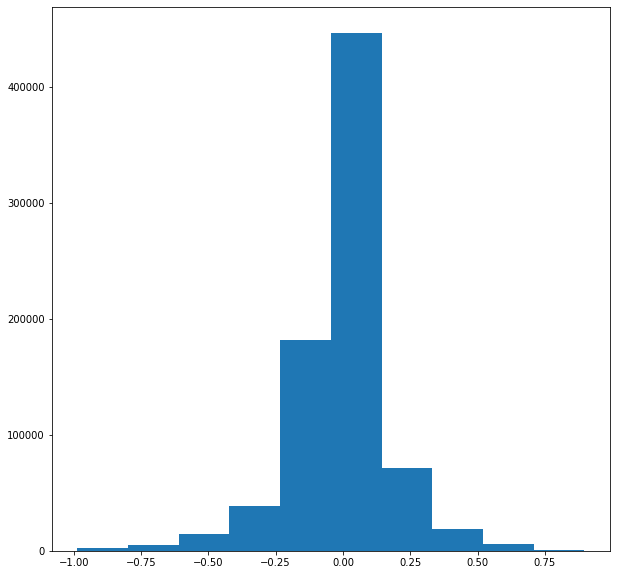

<Figure size 720x720 with 0 Axes>

In [24]:
sh_lb_difs = sh_lb_rea-sh_lb_aft
print(sh_lb_difs)
fig = plt.figure(figsize=(10,10))
plt.hist(sh_lb_difs.flatten())

fig = plt.figure(figsize=(10,10))
# torch.save(F.state_dict(), "./modelbest.mpy")